In [3]:
import nltk
from nltk.corpus import brown, stopwords
from collections import Counter
import matplotlib.pyplot as plt
import pyinflect
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
import spacy
import pandas as pd
from gensim.models import CoherenceModel
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from pprint import pprint
from wordcloud import WordCloud
import matplotlib.colors as mcolors
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import fuzzy, editdistance
from difflib import SequenceMatcher
import csv

nltk.download("brown")
nltk.download('punkt')
nltk.download('stopwords')

ModuleNotFoundError: No module named 'fuzzy'

In [3]:
# Combine files in ICE Nigeria to one in order to make things easier in future steps
if not os.path.exists("./ice_nig_combined.txt"):
    PATH = ".\\ice-nig\\txt - without speaker tags\\"
    files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(PATH) for f in filenames if os.path.splitext(f)[1] == '.txt']
    combined = ""
    for file in files:
        with open(file, "r", encoding="utf-8") as f:
            for line in f.readlines():
                combined += line
    with open("./ice_nig_combined.txt", "w", encoding="utf-8") as f:
        f.write(combined)
        

Inflections: ['hate', 'hates', 'hate', 'hate', 'hated', 'hated', 'hating', 'hates'] ['love', 'loves', 'love', 'love', 'loved', 'loved', 'loving', 'loves']
Occurances in brown: {'hate': 42, 'hates': 4, 'hated': 28, 'hating': 2} {'love': 214, 'loves': 19, 'loved': 56, 'loving': 14}
{'hate': 31, 'hates': 2, 'hated': 3, 'hating': 0}
Occurances in ice-nig: {'hate': 31, 'hates': 2, 'hated': 3, 'hating': 0} {'love': 256, 'loves': 11, 'loved': 32, 'loving': 15}


<BarContainer object of 4 artists>

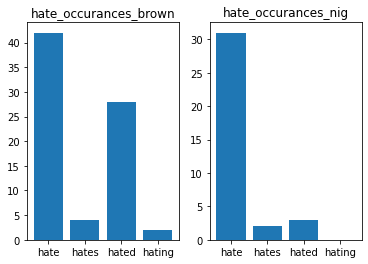

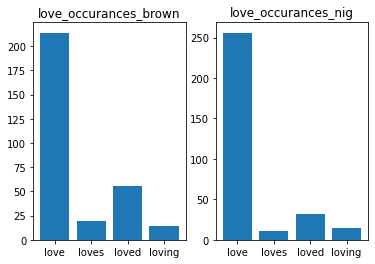

In [4]:
#1

hate_inflections = pyinflect.getAllInflections("hate")
love_inflections = pyinflect.getAllInflections("love")
hate_inflections_words = [x[0] for x in hate_inflections.values()]
love_inflections_words = [x[0] for x in love_inflections.values()]
print("Inflections:", hate_inflections_words, love_inflections_words)

with open("./ice_nig_combined.txt", "r", encoding="utf-8") as f:
    nig_ice_words = nltk.word_tokenize(f.read())
    

hate_occurances_brown, love_occurances_brown, hate_occurances_nig, love_occurances_nig = {}, {}, {}, {}
wordcounts_brown = Counter(brown.words())
wordcounts_nig = Counter(nig_ice_words)
for word in hate_inflections_words:
    hate_occurances_brown[word] = wordcounts_brown[word]
    hate_occurances_nig[word] = wordcounts_nig[word]
for word in love_inflections_words:
    love_occurances_brown[word] = wordcounts_brown[word]
    love_occurances_nig[word] = wordcounts_nig[word]
print("Occurances in brown:", hate_occurances_brown, love_occurances_brown)
print(hate_occurances_nig)
print("Occurances in ice-nig:", hate_occurances_nig, love_occurances_nig)


fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.title.set_text('hate_occurances_brown')
ax1.bar(hate_occurances_brown.keys(), hate_occurances_brown.values())
ax2.title.set_text('hate_occurances_nig')
plt.bar(hate_occurances_nig.keys(), hate_occurances_nig.values())

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.title.set_text('love_occurances_brown')
ax1.bar(love_occurances_brown.keys(), love_occurances_brown.values())
ax2.title.set_text('love_occurances_nig')
plt.bar(love_occurances_nig.keys(), love_occurances_nig.values())

In [5]:
#2

#remove stopwords and words without letters (e.g., "." or ",")
stop_words = set(stopwords.words('english'))
brown_filtered, ice_nig_filtered = [], []
for w in brown.words():
    if not w.lower() in stop_words:
        for c in w:
            if c.isalpha():
                brown_filtered.append(w.lower())
                break

for w in nig_ice_words:
    if not w.lower() in stop_words:
        for c in w:
            if c.isalpha():
                ice_nig_filtered.append(w.lower())
                break

#brown_filtered = [w for w in brown.words() if not w.lower() in stop_words]
#ice_nig_filtered = [w for w in nig_ice_words if not w.lower() in stop_words]

words_to_look_for = hate_inflections_words + love_inflections_words

#needed in task 4
hate_co_occurring_words_brown, love_co_occurring_words_brown = "", ""
hate_co_occurring_words_icenig, love_co_occurring_words_icenig = "", ""

co_occurring_words_brown = []
co_occurring_words_brown_hate, co_occurring_words_brown_love = [], []
for word in words_to_look_for:
    for ngram in nltk.ngrams(brown_filtered, 1):
        if word in ngram:
            for i in range(len(ngram)):
                if ngram[i] != word:
                    co_occurring_words_brown.append(ngram[i])
                    #needed in task 4
                    if word in hate_inflections_words:
                        hate_co_occurring_words_brown += ngram[i] + " "
                        co_occurring_words_brown_hate.append(ngram[i])
                    else:
                        love_co_occurring_words_brown += ngram[i] + " "
                        co_occurring_words_brown_love.append(ngram[i])
    for ngram in nltk.ngrams(brown_filtered, 2):
        if word in ngram:
            for i in range(len(ngram)):
                if ngram[i] != word:
                    co_occurring_words_brown.append(ngram[i])
                    #needed in task 4
                    if word in hate_inflections_words:
                        hate_co_occurring_words_brown += ngram[i] + " "
                        co_occurring_words_brown_hate.append(ngram[i])
                    else:
                        love_co_occurring_words_brown += ngram[i] + " "
                        co_occurring_words_brown_love.append(ngram[i])
    for ngram in nltk.ngrams(brown_filtered, 3):
        if word in ngram:
            for i in range(len(ngram)):
                if ngram[i] != word:
                    co_occurring_words_brown.append(ngram[i])
                    #needed in task 4
                    if word in hate_inflections_words:
                        hate_co_occurring_words_brown += ngram[i] + " "
                        co_occurring_words_brown_hate.append(ngram[i])
                    else:
                        love_co_occurring_words_brown += ngram[i] + " "
                        co_occurring_words_brown_love.append(ngram[i])

co_occurring_words_icenig = []
co_occurring_words_icenig_hate, co_occurring_words_icenig_love = [], []
for word in words_to_look_for:
    for ngram in nltk.ngrams(ice_nig_filtered, 1):
        if word in ngram:
            for i in range(len(ngram)):
                if ngram[i] != word:
                    co_occurring_words_icenig.append(ngram[i])
                    #needed in task 4
                    if word in hate_inflections_words:
                        hate_co_occurring_words_icenig += ngram[i] + " "
                        co_occurring_words_icenig_hate.append(ngram[i])
                    else:
                        love_co_occurring_words_icenig += ngram[i] + " "
                        co_occurring_words_icenig_love.append(ngram[i])
    for ngram in nltk.ngrams(ice_nig_filtered, 2):
        if word in ngram:
            for i in range(len(ngram)):
                if ngram[i] != word:
                    co_occurring_words_icenig.append(ngram[i])
                    #needed in task 4
                    if word in hate_inflections_words:
                        hate_co_occurring_words_icenig += ngram[i] + " "
                        co_occurring_words_icenig_hate.append(ngram[i])
                    else:
                        love_co_occurring_words_icenig += ngram[i] + " "
                        co_occurring_words_icenig_love.append(ngram[i])
    for ngram in nltk.ngrams(ice_nig_filtered, 3):
        if word in ngram:
            for i in range(len(ngram)):
                if ngram[i] != word:
                    co_occurring_words_icenig.append(ngram[i])
                    #needed in task 4
                    if word in hate_inflections_words:
                        hate_co_occurring_words_icenig += ngram[i] + " "
                        co_occurring_words_icenig_hate.append(ngram[i])
                    else:
                        love_co_occurring_words_icenig += ngram[i] + " "
                        co_occurring_words_icenig_love.append(ngram[i])
    


wordcounts_brown = Counter(co_occurring_words_brown)
wordcounts_brown_hate = Counter(co_occurring_words_brown_hate)
wordcounts_brown_love = Counter(co_occurring_words_brown_love)
wordcounts_icenig = Counter(co_occurring_words_icenig)
wordcounts_icenig_hate = Counter(co_occurring_words_icenig_hate)
wordcounts_icenig_love = Counter(co_occurring_words_icenig_love)
print("top50 wordcounts_brown:", wordcounts_brown.most_common(50), "\n")
print("top50 wordcounts_brown_hate:", wordcounts_brown_hate.most_common(50), "\n")
print("top50 wordcounts_brown_love:", wordcounts_brown_love.most_common(50), "\n")
print("top50 wordcounts_icenig:", wordcounts_icenig.most_common(50), "\n")
print("top50 wordcounts_icenig_hate:", wordcounts_icenig_hate.most_common(50), "\n")
print("top50 wordcounts_icenig_love:", wordcounts_icenig_love.most_common(50), "\n")

top50 wordcounts_brown: [('god', 105), ('man', 84), ('us', 63), ('one', 62), ('way', 59), ('know', 51), ('much', 49), ('even', 48), ('faith', 45), ('country', 44), ('said', 41), ('world', 41), ('mother', 39), ('little', 39), ('must', 38), ('like', 38), ('could', 36), ("i'd", 36), ('never', 36), ('true', 36), ('johnnie', 36), ('life', 35), ('yet', 35), ('love', 34), ('lost', 32), ('woman', 31), ('give', 30), ("mother's", 30), ('knowledge', 30), ('almost', 30), ('hate', 30), ('always', 30), ('boy', 29), ('fell', 29), ('men', 27), ('another', 27), ('well', 27), ('people', 27), ('fallen', 27), ('girl', 27), ('say', 26), ('children', 26), ('made', 24), ('brethren', 24), ('nature', 24), ('law', 24), ('feel', 23), ('beautiful', 23), ('sincere', 21), ('alive', 21)] 

top50 wordcounts_brown_hate: [('love', 30), ('say', 24), ('must', 24), ('one', 21), ('much', 21), ('feel', 20), ('cause', 18), ('alive', 18), ('said', 17), ('could', 15), ('woman', 15), ('sincere', 15), ('actually', 15), ('man', 1

In [6]:
#3

#Extract sentences from ice_nig to same format they are in brown.sents()
ice_nig_sents = []
with open("./ice_nig_combined.txt", "r", encoding="utf-8") as f:
    for line in f.readlines():
        temp = []
        for word in line.split(" "): 
            temp.append(word.strip("\n"))
        ice_nig_sents.append(temp)
    #print(ice_nig_sents[:20])


most_common_cowords_brown = [x[0] for x in wordcounts_brown.most_common(50)]
most_common_cowords_icenig = [x[0] for x in wordcounts_icenig.most_common(50)]
brown_sentences_hate = []
brown_sentences_love = []
i = 0
for word1 in most_common_cowords_brown:
    print(1, i, 50)
    i += 1
    for word2 in hate_inflections_words:
        for sent in brown.sents():
            for sent_ngram in nltk.ngrams(sent, 3): #3-grams should also include all 1s and 2s
                if word1 in sent_ngram and word2 in sent_ngram:
                    if sent not in brown_sentences_hate:
                        brown_sentences_hate.append(sent)
print("1 done")
i = 0
for word1 in most_common_cowords_brown:
    print(2, i, 50)
    i += 1
    for word2 in love_inflections_words:
        for sent in brown.sents():
            for sent_ngram in nltk.ngrams(sent, 3): #3-grams should also include all 1s and 2s
                if word1 in sent_ngram and word2 in sent_ngram:
                    if sent not in brown_sentences_love:
                        brown_sentences_love.append(sent)
print(len(brown_sentences_hate))
print(len(brown_sentences_love))

icenig_sentences_hate = []
icenig_sentences_love = []
i = 0
for word1 in most_common_cowords_icenig:
    print(1, i, 50)
    i += 1
    for word2 in hate_inflections_words:
        for sent in ice_nig_sents:
            for sent_ngram in nltk.ngrams(sent, 3): #3-grams should also include all 1s and 2s
                if word1 in sent_ngram and word2 in sent_ngram:
                    if sent not in icenig_sentences_hate:
                        icenig_sentences_hate.append(sent)
i = 0
for word1 in most_common_cowords_icenig:
    print(2, i, 50)
    i += 1
    for word2 in love_inflections_words:
        for sent in ice_nig_sents:
            for sent_ngram in nltk.ngrams(sent, 3): #3-grams should also include all 1s and 2s
                if word1 in sent_ngram and word2 in sent_ngram:
                    if sent not in icenig_sentences_love:
                        icenig_sentences_love.append(sent)
print(len(icenig_sentences_hate))
print(len(icenig_sentences_love))

with open("./brown_sentences_hate.txt", "w", encoding="utf-8") as f:
    for item in brown_sentences_hate:
        f.write(" ".join(item) + "\n")
with open("./brown_sentences_love.txt", "w", encoding="utf-8") as f:
    for item in brown_sentences_love:
        f.write(" ".join(item) + "\n")
with open("./icenig_sentences_hate.txt", "w", encoding="utf-8") as f:
    for item in icenig_sentences_hate:
        f.write(" ".join(item) + "\n")
with open("./icenig_sentences_love.txt", "w", encoding="utf-8") as f:
    for item in icenig_sentences_love:
        f.write(" ".join(item) + "\n")

1 0 50
1 1 50
1 2 50
1 3 50
1 4 50
1 5 50
1 6 50
1 7 50
1 8 50
1 9 50
1 10 50
1 11 50
1 12 50
1 13 50
1 14 50
1 15 50
1 16 50
1 17 50
1 18 50
1 19 50
1 20 50
1 21 50
1 22 50
1 23 50
1 24 50
1 25 50
1 26 50
1 27 50
1 28 50
1 29 50
1 30 50
1 31 50
1 32 50
1 33 50
1 34 50
1 35 50
1 36 50
1 37 50
1 38 50
1 39 50
1 40 50
1 41 50
1 42 50
1 43 50
1 44 50
1 45 50
1 46 50
1 47 50
1 48 50
1 49 50
1 done
2 0 50
2 1 50
2 2 50
2 3 50
2 4 50
2 5 50
2 6 50
2 7 50
2 8 50
2 9 50
2 10 50
2 11 50
2 12 50
2 13 50
2 14 50
2 15 50
2 16 50
2 17 50
2 18 50
2 19 50
2 20 50
2 21 50
2 22 50
2 23 50
2 24 50
2 25 50
2 26 50
2 27 50
2 28 50
2 29 50
2 30 50
2 31 50
2 32 50
2 33 50
2 34 50
2 35 50
2 36 50
2 37 50
2 38 50
2 39 50
2 40 50
2 41 50
2 42 50
2 43 50
2 44 50
2 45 50
2 46 50
2 47 50
2 48 50
2 49 50
43
224
1 0 50
1 1 50
1 2 50
1 3 50
1 4 50
1 5 50
1 6 50
1 7 50
1 8 50
1 9 50
1 10 50
1 11 50
1 12 50
1 13 50
1 14 50
1 15 50
1 16 50
1 17 50
1 18 50
1 19 50
1 20 50
1 21 50
1 22 50
1 23 50
1 24 50
1 25 50
1 26 50


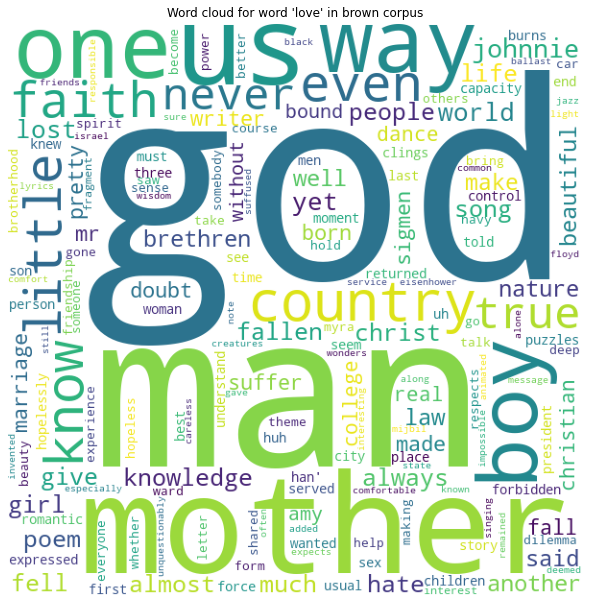

In [6]:
#4 Drawing word clouds for all the target words


#generate wordcloud
wordcloud = WordCloud(width = 600, height = 600,
                background_color ='white',
                collocations=False,
                min_font_size = 10).generate(love_co_occurring_words_brown)

#show plot
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Word cloud for word 'love' in brown corpus")
plt.show()

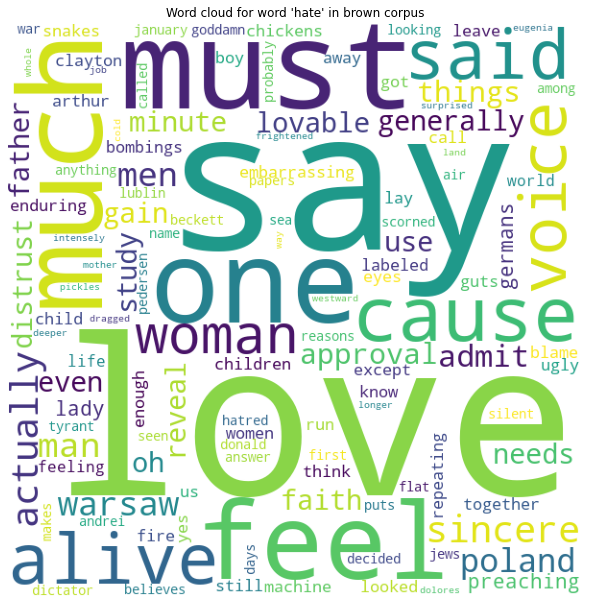

In [7]:
#generate wordcloud
wordcloud = WordCloud(width = 600, height = 600,
                background_color ='white',
                collocations=False,
                min_font_size = 10).generate(hate_co_occurring_words_brown)

#show plot
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Word cloud for word 'hate' in brown corpus")
plt.show()

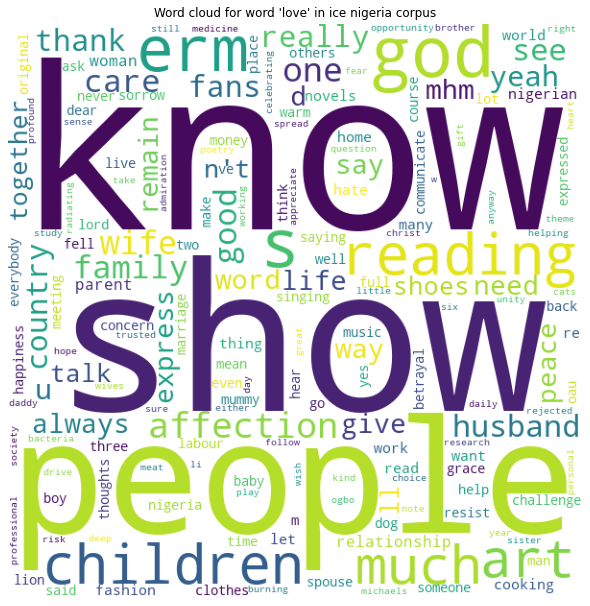

In [8]:
#generate wordcloud
wordcloud = WordCloud(width = 600, height = 600,
                background_color ='white',
                collocations=False,
                min_font_size = 10).generate(love_co_occurring_words_icenig)

#show plot
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Word cloud for word 'love' in ice nigeria corpus")
plt.show()

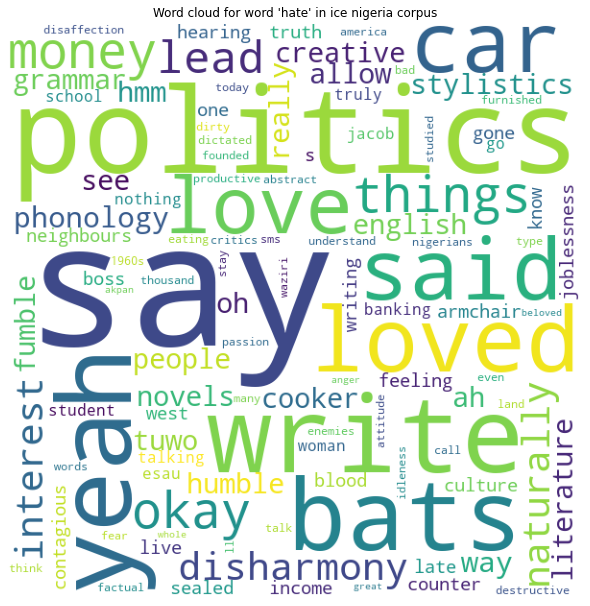

In [9]:
#generate wordcloud
wordcloud = WordCloud(width = 600, height = 600,
                background_color ='white',
                collocations=False,
                min_font_size = 10).generate(hate_co_occurring_words_icenig)

#show plot
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Word cloud for word 'hate' in ice nigeria corpus")
plt.show()

In [16]:
#6 The representation is here so it can be called later

#Wordcloud of Top N words in each topic


def topic_representation(LDAmodel, stopWords):
    #colors
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    #create a word cloud
    cloud = WordCloud(stopwords=stopWords,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    #get topics
    topics = LDAmodel.show_topics(formatted=False)
    #create figures for 10 topics as 2x5 (2columns, 5rows)
    fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

C:\Users\Lassi\AppData\Local\Programs\Python\Python310\lib\site-packages\spacy\language.py:1895: UserWarning: [W123] Argument disable with value ['parser', 'ner'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  warnings.warn(


[(0,
  '0.082*"hate" + 0.024*"love" + 0.024*"word" + 0.013*"woman" + '
  '0.013*"pathogenic" + 0.013*"earth" + 0.013*"none" + 0.013*"emerge" + '
  '0.013*"begin" + 0.013*"introject"'),
 (1,
  '0.064*"hate" + 0.044*"distrust" + 0.023*"use" + 0.023*"review" + '
  '0.023*"support" + 0.023*"begin" + 0.023*"mind" + 0.023*"gain" + '
  '0.023*"graver" + 0.023*"irishman"'),
 (2,
  '0.004*"meanwhile" + 0.004*"sequence" + 0.004*"love" + 0.004*"wonderful" + '
  '0.004*"feel" + 0.004*"kill" + 0.004*"live" + 0.004*"dinner" + 0.004*"think" '
  '+ 0.004*"good"'),
 (3,
  '0.068*"hate" + 0.035*"reason" + 0.018*"mood" + 0.018*"theatergoer" + '
  '0.018*"enright" + 0.018*"sing" + 0.018*"permanently" + 0.018*"easily" + '
  '0.018*"pretty" + 0.018*"good"'),
 (4,
  '0.005*"say" + 0.004*"hate" + 0.004*"gut" + 0.004*"think" + 0.004*"mother" + '
  '0.004*"make" + 0.004*"leave" + 0.004*"come" + 0.004*"boy" + 0.004*"hear"'),
 (5,
  '0.042*"assignment" + 0.042*"hate" + 0.022*"interposition" + 0.022*"oppose" '
  '

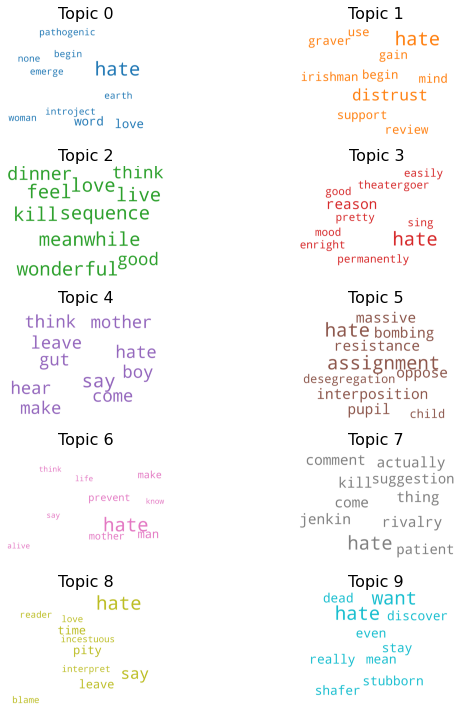

[(0,
  '0.069*"love" + 0.018*"marriage" + 0.017*"help" + 0.013*"try" + '
  '0.013*"advice" + 0.013*"innocent" + 0.013*"town" + 0.012*"gift" + '
  '0.012*"respect" + 0.011*"unadulterated"'),
 (1,
  '0.098*"love" + 0.029*"girl" + 0.021*"time" + 0.018*"real" + 0.018*"man" + '
  '0.016*"never" + 0.015*"child" + 0.015*"lose" + 0.013*"experience" + '
  '0.013*"bring"'),
 (2,
  '0.029*"love" + 0.017*"call" + 0.015*"impossible" + 0.015*"problem" + '
  '0.014*"go" + 0.013*"scenario" + 0.013*"sexy" + 0.013*"hammer" + '
  '0.013*"lascivious" + 0.013*"operator"'),
 (3,
  '0.037*"car" + 0.035*"love" + 0.028*"recent" + 0.025*"motor" + 0.018*"take" '
  '+ 0.017*"give" + 0.016*"use" + 0.015*"failure" + 0.014*"call" + '
  '0.012*"useless"'),
 (4,
  '0.059*"love" + 0.037*"give" + 0.031*"kid" + 0.023*"think" + 0.023*"also" + '
  '0.018*"pure" + 0.018*"keep" + 0.018*"many" + 0.018*"small" + 0.016*"save"'),
 (5,
  '0.033*"love" + 0.029*"kind" + 0.024*"marry" + 0.021*"enough" + 0.021*"old" '
  '+ 0.021*"pas

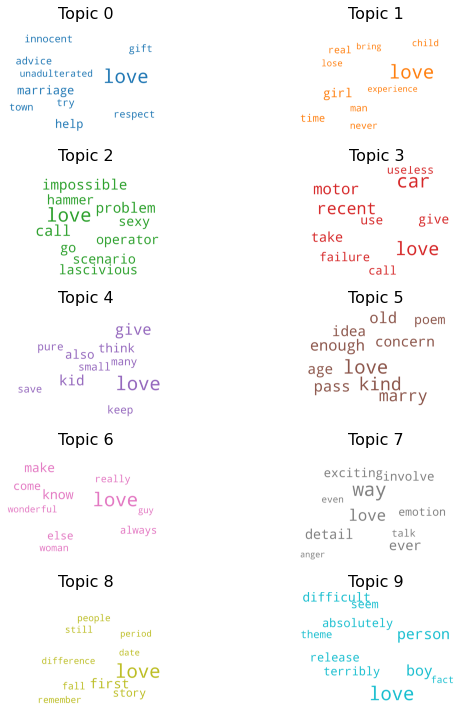

[(0,
  '0.235*"say" + 0.159*"hate" + 0.083*"live" + 0.083*"furnish" + 0.083*"flat" '
  '+ 0.083*"car" + 0.083*"great" + 0.083*"bank" + 0.008*"politic" + '
  '0.008*"love"'),
 (1,
  '0.045*"hate" + 0.045*"say" + 0.045*"politic" + 0.045*"love" + 0.045*"see" + '
  '0.045*"woman" + 0.045*"furnish" + 0.045*"great" + 0.045*"live" + '
  '0.045*"respond"'),
 (2,
  '0.212*"politic" + 0.212*"see" + 0.212*"hate" + 0.019*"say" + 0.019*"love" + '
  '0.019*"great" + 0.019*"car" + 0.019*"live" + 0.019*"furnish" + '
  '0.019*"bank"'),
 (3,
  '0.172*"politic" + 0.172*"talk" + 0.090*"analyst" + 0.090*"people" + '
  '0.090*"believe" + 0.090*"even" + 0.090*"liar" + 0.090*"hate" + 0.008*"say" '
  '+ 0.008*"love"'),
 (4,
  '0.045*"hate" + 0.045*"politic" + 0.045*"say" + 0.045*"love" + 0.045*"see" + '
  '0.045*"great" + 0.045*"worldly" + 0.045*"talk" + 0.045*"furnish" + '
  '0.045*"woman"'),
 (5,
  '0.262*"politic" + 0.262*"hate" + 0.024*"say" + 0.024*"love" + 0.024*"see" + '
  '0.024*"live" + 0.024*"woman" 

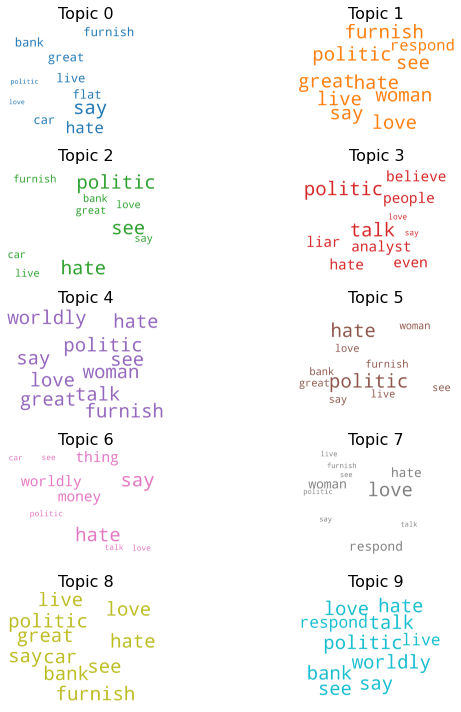

[(0,
  '0.014*"erm" + 0.014*"know" + 0.012*"say" + 0.011*"go" + 0.010*"state" + '
  '0.009*"people" + 0.007*"come" + 0.007*"today" + 0.007*"make" + '
  '0.006*"want"'),
 (1,
  '0.004*"husband" + 0.003*"love" + 0.002*"word" + 0.002*"care" + 0.002*"wear" '
  '+ 0.002*"comfortable" + 0.002*"novel" + 0.002*"commandment" + '
  '0.002*"manolin" + 0.002*"beyonce"'),
 (2,
  '0.002*"many" + 0.002*"peace" + 0.002*"background" + 0.002*"creature" + '
  '0.002*"frustrate" + 0.002*"cheer" + 0.002*"spanish" + 0.001*"know" + '
  '0.001*"hear" + 0.001*"language"'),
 (3,
  '0.004*"love" + 0.002*"life" + 0.002*"word" + 0.002*"campaign" + '
  '0.002*"express" + 0.002*"action" + 0.002*"urge" + 0.002*"suppose" + '
  '0.002*"stadium" + 0.002*"daily"'),
 (4,
  '0.008*"week" + 0.007*"man" + 0.007*"state" + 0.007*"say" + 0.006*"take" + '
  '0.005*"also" + 0.005*"make" + 0.005*"country" + 0.005*"life" + '
  '0.005*"government"'),
 (5,
  '0.010*"people" + 0.009*"state" + 0.008*"know" + 0.008*"country" + '
  '0.00

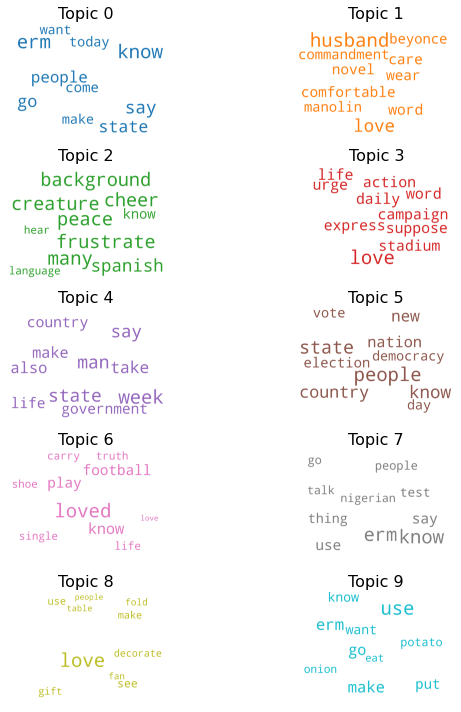

In [14]:
#5
# opening the file in read mode
#my_file = open("ice_nig_combined.txt", "r", encoding="utf-8")
  
# reading the file
#data = my_file.read()
  
# replacing end of line('/n') with ' ' and
# splitting the text it further when '.' is seen.
#data_into_list = data.replace('\n', ' ').split(".")
                              
#def sent_to_words(sentences):
#    for sentence in sentences:
#        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

#data_words = list(sent_to_words(data_into_list))
#brown_sentences_hate
#brown_sentences_love
#icenig_sentences_hate
#icenig_sentences_love

alldocuments = [brown_sentences_hate, brown_sentences_love, icenig_sentences_hate, icenig_sentences_love]

def LDA_implementation(data_words):

    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # Define functions for stopwords, bigrams, trigrams and lemmatization
    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]

    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out

    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)

    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

    nlp.max_length = 1031272

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)

    # Create Corpus
    texts = data_lemmatized

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]


    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=10, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
    return lda_model, corpus

for sentences in alldocuments:
    LDA_model, corpus = LDA_implementation(sentences)
    pprint(LDA_model.print_topics())
    topic_representation(LDA_model, stop_words)
#doc_lda = lda_model[corpus]

In [15]:
#7

text_brown_sentences_hate = ""
with open("./brown_sentences_hate.txt", "r", encoding="utf-8") as f:
    for line in f.readlines():
        text_brown_sentences_hate += line
sentiment_brown_sentences_hate = SentimentIntensityAnalyzer().polarity_scores(text_brown_sentences_hate)

text_brown_sentences_love = ""
with open("./brown_sentences_love.txt", "r", encoding="utf-8") as f:
    for line in f.readlines():
        text_brown_sentences_love += line
sentiment_brown_sentences_love = SentimentIntensityAnalyzer().polarity_scores(text_brown_sentences_love)

text_icenig_sentences_hate = ""
with open("./icenig_sentences_hate.txt", "r", encoding="utf-8") as f:
    for line in f.readlines():
        text_icenig_sentences_hate += line
sentiment_icenig_sentences_hate = SentimentIntensityAnalyzer().polarity_scores(text_icenig_sentences_hate)

text_icenig_sentences_love = ""
with open("./icenig_sentences_love.txt", "r", encoding="utf-8") as f:
    for line in f.readlines():
        text_icenig_sentences_love += line
sentiment_icenig_sentences_love = SentimentIntensityAnalyzer().polarity_scores(text_icenig_sentences_love)

print("brown_sentences_hate.txt - Polarity scores:{}".format(sentiment_brown_sentences_hate))
print("brown_sentences_love.txt - Polarity scores:{}".format(sentiment_brown_sentences_love))
print("icenig_sentences_hate.txt - Polarity scores:{}".format(sentiment_icenig_sentences_hate))
print("icenig_sentences_love.txt - Polarity scores:{}".format(sentiment_icenig_sentences_love))

brown_sentences_hate.txt - Polarity scores:{'neg': 0.258, 'neu': 0.643, 'pos': 0.099, 'compound': -0.9997}
brown_sentences_love.txt - Polarity scores:{'neg': 0.07, 'neu': 0.667, 'pos': 0.262, 'compound': 1.0}
icenig_sentences_hate.txt - Polarity scores:{'neg': 0.16, 'neu': 0.613, 'pos': 0.227, 'compound': 0.8481}
icenig_sentences_love.txt - Polarity scores:{'neg': 0.051, 'neu': 0.802, 'pos': 0.147, 'compound': 1.0}


In [4]:
#8 
#extract all words and corresponding tags from brown.tagged_words()
all_words_brown, all_tags = [], []
for item in brown.tagged_words():
    all_words_brown.append(item[0])
    all_tags.append(item[1])

# start by finding all adverbs and adjectives that are in a 3 token distance from target words in brown corpus
max_index = len(all_words_brown) - 1
love_tags_brown, hate_tags_brown, love_words_brown, hate_words_brown = [], [], [], []
for index, word in enumerate(all_words_brown):
    if word.lower() in love_inflections_words:
        #go through words that are in 3 token distance from the target word
        for i in range((max(0, index-3)), 1+(min(max_index, index+3))):
            #if this is not target word and tag says it is adverb or adjective, add it to list
            if i != index and (all_tags[i].startswith('R') or all_tags[i].startswith('J')):
                love_tags_brown.append(all_tags[i])
                love_words_brown.append(all_words_brown[i].lower())
    elif word.lower() in hate_inflections_words:
        #go through words that are in 3 token distance from the target word
        for i in range((max(0, index-3)), 1+(min(max_index, index+3))):
            #if this is not target word and tag says it is adverb or adjective, add it to list
            if i != index and (all_tags[i].startswith('R') or all_tags[i].startswith('J')):
                hate_tags_brown.append(all_tags[i])
                hate_words_brown.append(all_words_brown[i].lower())
                
#do the same for ice nigerian corpus
max_index = len(nig_ice_words) - 1
love_tags_nig, hate_tags_nig, love_words_nig, hate_words_nig = [], [], [], []
for index, word in enumerate(nig_ice_words):
    if word.lower() in love_inflections_words:
        #go through words that are in 3 token distance from the target word
        for i in range((max(0, index-3)), 1+(min(max_index, index+3))):
            #if this is not target word and tag says it is adverb or adjective, add it to list
            if i != index:
                #find that word in brown corpus
                for k, b_word in enumerate(all_words_brown):
                    if nig_ice_words[i].lower() == b_word.lower():
                        #if the same was word found, check the tag and break loop afterwards
                        if all_tags[k].startswith('R') or all_tags[k].startswith('J'):
                            love_tags_nig.append(all_tags[k])
                            love_words_nig.append(nig_ice_words[i].lower())
                        break
    elif word.lower() in hate_inflections_words:
        #go through words that are in 3 token distance from the target word
        for i in range((max(0, index-3)), 1+(min(max_index, index+3))):
            #if this is not target word and tag says it is adverb or adjective, add it to list
            if i != index:
                #find that word in brown corpus
                for k, b_word in enumerate(all_words_brown):
                    if nig_ice_words[i].lower() == b_word.lower():
                        #if the same was word found, check the tag and break loop afterwards
                        if all_tags[k].startswith('R') or all_tags[k].startswith('J'):
                            hate_tags_nig.append(all_tags[k])
                            hate_words_nig.append(nig_ice_words[i].lower())
                        break

In [5]:
#find 50 most co-occurring adverbs and adjectives
co_word_count_brown = Counter(love_words_brown+hate_words_brown)
co_word_count_nig = Counter(love_words_nig+hate_words_nig)

#save counts to dictionaries
word_count_nig_dict, word_count_brown_dict = {}, {}
for item in co_word_count_brown:
    word_count_brown_dict[item] = co_word_count_brown[item]
for item in co_word_count_nig:
    word_count_nig_dict[item] = co_word_count_nig[item]
#sorted values in new dictionaries
sorted_brown_values = sorted(word_count_brown_dict.values(), reverse=True)
sorted_nig_values = sorted(word_count_nig_dict.values(), reverse=True)

#add sorted values to new sorted dictionaries
sorted_brown_dict, sorted_nig_dict = {}, {}
for i in sorted_brown_values:
    for k in word_count_brown_dict.keys():
        if word_count_brown_dict[k] == i:
            sorted_brown_dict[k] = word_count_brown_dict[k]
            
for i in sorted_nig_values:
    for k in word_count_nig_dict.keys():
        if word_count_nig_dict[k] == i:
            sorted_nig_dict[k] = word_count_nig_dict[k]         

#print results
rank = 0
print("50 most co-occurring adverbs/adjectives, corpus: brown")
for index, item in enumerate(sorted_brown_dict):
    rank += 1
    print(rank, item, sorted_brown_values[index])
    if index >= 49:
        break
rank = 0
print("\n50 most co-occurring adverbs/adjectives, corpus: ice nigerian")
for index, item in enumerate(sorted_nig_dict):
    rank += 1
    print(rank,item, sorted_nig_values[index])
    if index >= 49:
        break


50 most co-occurring adverbs/adjectives, corpus: brown
1 even 8
2 much 6
3 again 4
4 so 4
5 never 4
6 true 4
7 sincere 3
8 now 3
9 beautiful 2
10 usual 2
11 once 2
12 deep 2
13 pretty 2
14 longer 2
15 christian 2
16 just 2
17 up 2
18 best 2
19 only 2
20 hopeless 2
21 little 2
22 too 2
23 together 2
24 romantic 2
25 yet 2
26 well 2
27 more 2
28 almost 2
29 down 2
30 most 2
31 back 2
32 unquestionably 2
33 real 2
34 still 2
35 better 2
36 hopelessly 2
37 such 2
38 alive 2
39 also 1
40 enough 1
41 responsible 1
42 persistent 1
43 light 1
44 abrupt 1
45 careless 1
46 nearest 1
47 common 1
48 captivating 1
49 slavic 1
50 earlier 1

50 most co-occurring adverbs/adjectives, corpus: ice nigerian
1 just 9
2 really 8
3 yeah 7
4 also 6
5 here 5
6 then 5
7 good 5
8 always 5
9 now 3
10 yes 3
11 together 3
12 out 3
13 great 3
14 deep 2
15 full 2
16 back 2
17 warm 2
18 over 2
19 truly 2
20 never 2
21 dear 2
22 personal 1
23 foreign 1
24 yet 1
25 profound 1
26 healthy 1
27 technical 1
28 muslim 1
29 s

Counter({'JJ': 76, 'RB': 70, 'RBR': 5, 'RP': 5, 'JJT': 3, 'JJR': 3, 'JJ-TL': 2, 'RBT': 2, 'RB-TL': 1})
Counter({'RB': 16, 'JJ': 14, 'JJR': 3, 'RBT': 2, 'RBR': 1, 'RP': 1})
Counter({'RB': 72, 'JJ': 44, 'RP': 5, 'JJ-HL': 2, 'JJ-TL': 1})
Counter({'RB': 9, 'JJ': 8, 'JJ-TL': 1, 'RP': 1})


<BarContainer object of 4 artists>

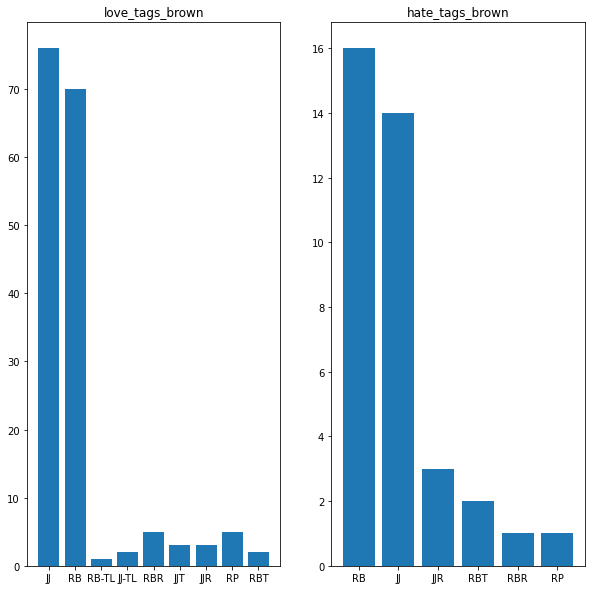

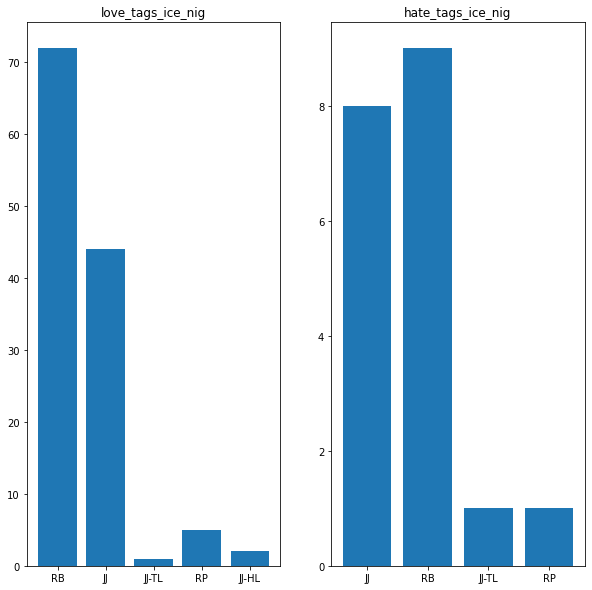

In [6]:
#show histogram of tags
love_tag_count_brown = Counter(love_tags_brown)
hate_tag_count_brown = Counter(hate_tags_brown)
love_tag_count_nig = Counter(love_tags_nig)
hate_tag_count_nig = Counter(hate_tags_nig)
print(love_tag_count_brown)
print(hate_tag_count_brown)
print(love_tag_count_nig)
print(hate_tag_count_nig)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.title.set_text('love_tags_brown')
ax1.bar(love_tag_count_brown.keys(), love_tag_count_brown.values())
ax2.title.set_text('hate_tags_brown')
plt.bar(hate_tag_count_brown.keys(), hate_tag_count_brown.values())

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.title.set_text('love_tags_ice_nig')
ax1.bar(love_tag_count_nig.keys(), love_tag_count_nig.values())
ax2.title.set_text('hate_tags_ice_nig')
plt.bar(hate_tag_count_nig.keys(), hate_tag_count_nig.values())

H300 L100


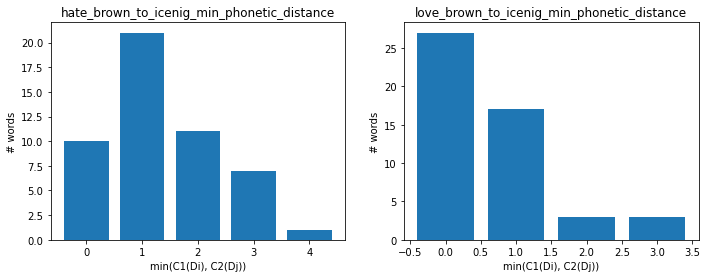

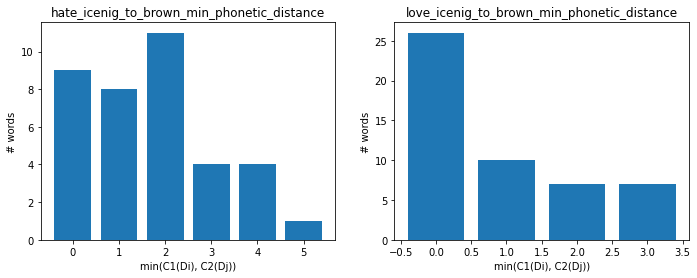

In [23]:
#9 


soundex = fuzzy.Soundex(50) 
hate_soundex, love_soundex = soundex('hate')[0:4], soundex('love')[0:4]
print(hate_soundex, love_soundex)

#Get co-occuring words of distance 1 for each corpus
ice_nig_hate_dist1_cooccur, ice_nig_love_dist1_cooccur = [], []
brown_hate_dist1_cooccur, brown_love_dist1_cooccur = [], []
with open("./ice_nig_combined.txt", "r", encoding="utf-8") as f:
    for line in f.readlines():
        sp = line.split(" ")
        for i in range(len(sp)):
            if sp[i] in hate_inflections_words:
                try:
                    ice_nig_hate_dist1_cooccur.append(sp[i-1].strip("\n"))
                except:
                    pass #hate was the first word
                try:
                    ice_nig_hate_dist1_cooccur.append(sp[i+1].strip("\n"))
                except:
                    pass #hate was the last word
            if sp[i] in love_inflections_words:
                try:
                    ice_nig_love_dist1_cooccur.append(sp[i-1].strip("\n"))
                except:
                    pass #love was the first word
                try:
                    ice_nig_love_dist1_cooccur.append(sp[i+1].strip("\n"))
                except:
                    pass #love was the last word
#print(ice_nig_hate_dist1_cooccur[:10], ice_nig_love_dist1_cooccur[:10])
for sentence in brown.sents():
    for i in range(len(sentence)):
        if sentence[i] in hate_inflections_words:
            try:
                brown_hate_dist1_cooccur.append(sentence[i-1].strip("\n"))
            except:
                pass #hate was the first word
            try:
                brown_hate_dist1_cooccur.append(sentence[i+1].strip("\n"))
            except:
                pass #hate was the last word
        if sentence[i] in love_inflections_words:
            try:
                brown_love_dist1_cooccur.append(sentence[i-1].strip("\n"))
            except:
                pass #love was the first word
            try:
                brown_love_dist1_cooccur.append(sentence[i+1].strip("\n"))
            except:
                pass #love was the last word
#print(brown_hate_dist1_cooccur[:10], brown_love_dist1_cooccur[:10])

#Get soundexes for each word
brown_word_to_soundex_hate, brown_word_to_soundex_love = {}, {}
for word in Counter(brown_hate_dist1_cooccur).most_common(50):
    brown_word_to_soundex_hate[word[0]] = soundex(word[0])[0:len(word[0])]
for word in Counter(brown_love_dist1_cooccur).most_common(50):
    brown_word_to_soundex_love[word[0]] = soundex(word[0])[0:len(word[0])]
#print(brown_word_to_soundex_hate, brown_word_to_soundex_love)

ice_nig_word_to_soundex_hate, ice_nig_word_to_soundex_love = {}, {}
for word in Counter(ice_nig_hate_dist1_cooccur).most_common(50):
    ice_nig_word_to_soundex_hate[word[0].strip('“')] = soundex(word[0].strip('“'))[0:len(word[0])]
for word in Counter(ice_nig_love_dist1_cooccur).most_common(50):
    ice_nig_word_to_soundex_love[word[0].strip('“')] = soundex(word[0].strip('“'))[0:len(word[0])]
#print(ice_nig_word_to_soundex_hate, ice_nig_word_to_soundex_love)

#hate (brown to icenig)
hate_brown_to_icenig_dists = []
for key, value in brown_word_to_soundex_hate.items():
    temp = []
    for key2, value2 in ice_nig_word_to_soundex_hate.items():
        temp.append(editdistance.eval(value, value2))
    hate_brown_to_icenig_dists.append(min(temp))
#love (brown to icenig)
love_brown_to_icenig_dists = []
for key, value in brown_word_to_soundex_love.items():
    temp = []
    for key2, value2 in ice_nig_word_to_soundex_love.items():
        temp.append(editdistance.eval(value, value2))
    love_brown_to_icenig_dists.append(min(temp))
    
#hate (icenig to brown)
hate_icenig_to_brown_dists = []
for key, value in ice_nig_word_to_soundex_hate.items():
    temp = []
    for key2, value2 in brown_word_to_soundex_hate.items():
        temp.append(editdistance.eval(value, value2))
    hate_icenig_to_brown_dists.append(min(temp))
#love (icenig to brown)
love_icenig_to_brown_dists = []
for key, value in ice_nig_word_to_soundex_love.items():
    temp = []
    for key2, value2 in brown_word_to_soundex_love.items():
        temp.append(editdistance.eval(value, value2))
    love_icenig_to_brown_dists.append(min(temp))

#print(hate_brown_to_icenig_dists, love_brown_to_icenig_dists, hate_icenig_to_brown_dists, love_icenig_to_brown_dists)


fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.title.set_text('hate_brown_to_icenig_min_phonetic_distance')
ax1.bar(Counter(hate_brown_to_icenig_dists).keys(), Counter(hate_brown_to_icenig_dists).values())
ax1.set_ylabel("# words")
ax1.set_xlabel("min(C1(Di), C2(Dj))")
ax2.title.set_text('love_brown_to_icenig_min_phonetic_distance')
plt.bar(Counter(love_brown_to_icenig_dists).keys(), Counter(love_brown_to_icenig_dists).values())
ax2.set_ylabel("# words")
ax2.set_xlabel("min(C1(Di), C2(Dj))")
plt.subplots_adjust(left=0,
                    right=1.5)

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.title.set_text('hate_icenig_to_brown_min_phonetic_distance')
ax1.bar(Counter(hate_icenig_to_brown_dists).keys(), Counter(hate_icenig_to_brown_dists).values())
ax1.set_ylabel("# words")
ax1.set_xlabel("min(C1(Di), C2(Dj))")
ax2.title.set_text('love_icenig_to_brown_min_phonetic_distance')
plt.bar(Counter(love_icenig_to_brown_dists).keys(), Counter(love_icenig_to_brown_dists).values())
ax2.set_ylabel("# words")
ax2.set_xlabel("min(C1(Di), C2(Dj))")
plt.subplots_adjust(left=0,
                    right=1.5)




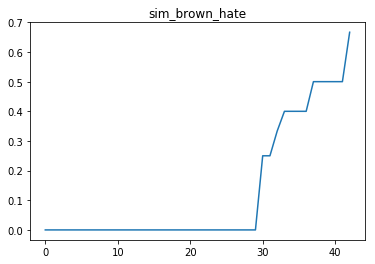

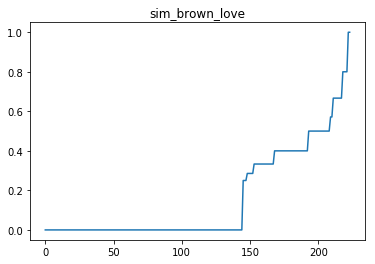

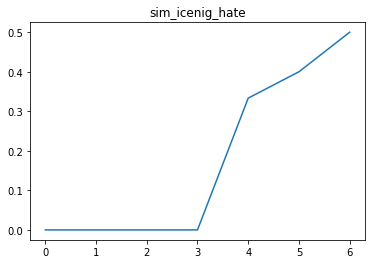

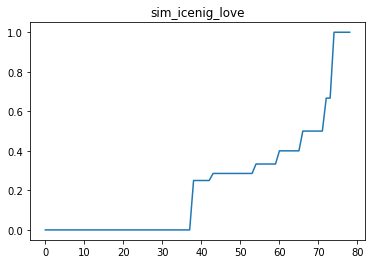

In [12]:
#10

soundex = fuzzy.Soundex(4) 

sim_brown_hate = []
sim_brown_love = []
sim_icenig_hate = []
sim_icenig_love = []

with open("./brown_sentences_hate.txt", "r", encoding="utf-8") as f:
    for line in f.readlines():
        sp = line.strip(' -"()?!:;,.\n').strip("`'").replace(".","").strip().split(" ")
        match = SequenceMatcher(None, sp[0],sp[-1]).find_longest_match(0, len(sp[0]), 0, len(sp[-1]))
        s = (sp[0][match.b:match.b + match.size])
        l1 = soundex(sp[0]).rstrip("0")
        l2 = soundex(sp[-1]).rstrip("0")
        sim = 2*len(s)/(len(l1) + len(l2))
        sim_brown_hate.append([sp[0],sp[-1],sim])
sim_brown_hate.sort(key=lambda x: x[2])

with open("./brown_sentences_love.txt", "r", encoding="utf-8") as f:
    for line in f.readlines():
        sp = line.strip(' -"()?!:;,.\n').strip("`'").replace(".","").strip().split(" ")
        match = SequenceMatcher(None, sp[0],sp[-1]).find_longest_match(0, len(sp[0]), 0, len(sp[-1]))
        s = (sp[0][match.b:match.b + match.size])
        l1 = soundex(sp[0]).rstrip("0")
        l2 = soundex(sp[-1]).rstrip("0")
        sim = 2*len(s)/(len(l1) + len(l2))
        sim_brown_love.append([sp[0],sp[-1],sim])
sim_brown_love.sort(key=lambda x: x[2])

with open("./icenig_sentences_hate.txt", "r", encoding="utf-8") as f:
    for line in f.readlines():
        sp = line.strip(' -"()?!:;,.\n').strip("`'").replace(".","").strip().split(" ")
        match = SequenceMatcher(None, sp[0],sp[-1]).find_longest_match(0, len(sp[0]), 0, len(sp[-1]))
        s = (sp[0][match.b:match.b + match.size])
        l1 = soundex(sp[0]).rstrip("0")
        l2 = soundex(sp[-1]).rstrip("0")
        sim = 2*len(s)/(len(l1) + len(l2))
        sim_icenig_hate.append([sp[0],sp[-1],sim])
sim_icenig_hate.sort(key=lambda x: x[2])

with open("./icenig_sentences_love.txt", "r", encoding="utf-8") as f:
    for line in f.readlines():
        sp = line.strip(' -"()?!:;,.\n').strip("`'").replace(".","").strip().split(" ")
        match = SequenceMatcher(None, sp[0],sp[-1]).find_longest_match(0, len(sp[0]), 0, len(sp[-1]))
        s = (sp[0][match.b:match.b + match.size])
        l1 = soundex(sp[0]).rstrip("0")
        l2 = soundex(sp[-1]).rstrip("0")
        sim = 2*len(s)/(len(l1) + len(l2))
        sim_icenig_love.append([sp[0],sp[-1],sim])
sim_icenig_love.sort(key=lambda x: x[2])


with open("brown_sentences_hate_similarity.csv", "w", encoding="utf-8") as f:
    csvwriter = csv.writer(f, delimiter=",")
    for simvalue in sim_brown_hate:
        csvwriter.writerow(simvalue)

with open("brown_sentences_love_similarity.csv", "w", encoding="utf-8") as f:
    csvwriter = csv.writer(f, delimiter=",")
    for simvalue in sim_brown_love:
        csvwriter.writerow(simvalue)
       
with open("icenig_sentences_hate_similarity.csv", "w", encoding="utf-8") as f:
    csvwriter = csv.writer(f, delimiter=",")
    for simvalue in sim_icenig_hate:
        csvwriter.writerow(simvalue)
        
with open("icenig_sentences_love_similarity.csv", "w", encoding="utf-8") as f:
    csvwriter = csv.writer(f, delimiter=",")
    for simvalue in sim_icenig_love:
        csvwriter.writerow(simvalue)
        
plt.title("sim_brown_hate") 
plt.plot([item[2] for item in sim_brown_hate]) 
plt.show() 

plt.title("sim_brown_love") 
plt.plot([item[2] for item in sim_brown_love]) 
plt.show() 

plt.title("sim_icenig_hate") 
plt.plot([item[2] for item in sim_icenig_hate]) 
plt.show() 
     
plt.title("sim_icenig_love") 
plt.plot([item[2] for item in sim_icenig_love]) 
plt.show() 